In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from textwrap import indent
from IPython.display import Javascript
from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side
from IPython.display import Latex
from fractions import Fraction
import importlib
from core.arithmetic_manager import ArithManager
from core.util import *
from core.shunting_yard_parser import ShuntingYardParser
from core.arithmetic_manager import ArithManager
from core.util import *

In [3]:
def ast_eval(ast, show_blocks, show_latex):
    AM = ArithManager()
    
    blocks = AM.blocks(ast)
    
    if show_blocks: print(blocks)
        
    MEMORY = dict(blocks)
    main_block = blocks[-1][1]
    child_to_calc = None
    current_block = block_id = None

    while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]

    while blocks:
        block_id, current_block = blocks[0]
        parent_to_calc = AM.prior(current_block)
        tex = AM.latex(main_block, MEMORY)
        if show_latex: display_latex(tex)
        
        parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                    if is_next_to_calc(child) else child
                                    for child in parent_to_calc.children]

        if is_calculable(current_block):
            current_block = current_block.children[0]
            blocks = blocks[1:]

        MEMORY[block_id] = current_block

    tex = AM.latex(main_block, {})
    if show_latex: display_latex(tex)
    
    return main_block.children[0].root['value']


def antlr_eval(expr, show_ptree = False, show_ast = False, show_blocks = False, show_latex = False):
    AM = ArithManager()
    ptree = AM.ptree('antlrGrammar.g',expr)
    if show_ptree: display(ptree)
    
    ast = AM.ptree2ast(ptree)
    if show_ast: display(ast)
    return ast_eval(ast, show_blocks, show_latex)


def shunting_eval(expr, show_ast = False, show_blocks = False, show_latex = False):
    AM = ArithManager()

    ast = AM.shuntingYardExpr2ast(expr)
    if show_ast: display(ast)

    return ast_eval(ast, show_blocks, show_latex)

In [4]:
from core.expression_generator import generate_expression

wrong_expr = []
for _ in range(30):
    exception = False
    expr = generate_expression(4)
    
    try:
        antlr_res = antlr_eval(expr)
    except Exception as e:
        exception = True

    try:
        shunting_res = shunting_eval(expr)
        if exception: 
            wrong_expr.append(expr)
            continue
    except Exception as e:
        print('** EXCEPTION SHUNTING ** ', e)
        if not exception: 
            wrong_expr.append(expr)
        continue

    formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')
    res =  round(eval(formatted_expr), 3)

    if antlr_res != shunting_res or abs(antlr_res - res) > 1:
        wrong_expr.append(expr)
        
    
    #print(antlr_res, shunting_res, res)
        
if wrong_expr != []:
    print(f'*** WRONG {len(wrong_expr)} ***\n')
    for i, it in enumerate(wrong_expr):
        print(f' $$$ {i} $$$  ', it)
else:
    print("ALL DONE")

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
** EXCEPTION SHUNTING **  can't convert complex to int
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code ve

['39', '/', '--', '15', '/', '16']


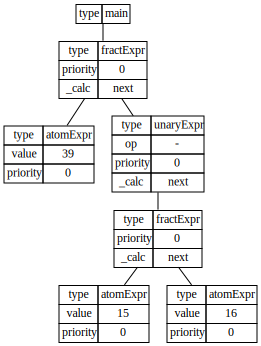

In [30]:
shunting_yard_parser = ShuntingYardParser()

ast = shunting_yard_parser.parse(expr)
ast_eval(ast, False, False)
ast

In [59]:
expr = '  84  / - 55 ^ -2 x ( 34 x 43 ) ^ -2 ^ -2 x ( 100000 ^ -2 ^ 2 x - 2 x 28 - - 48 )'

formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')
real_expr = expr.replace('x', '*').replace(':', '/')
print(real_expr)
res =  round(eval(formatted_expr), 3)
shunt = shunting_eval(expr, show_latex=True)
ant = antlr_eval(expr, False, False)
print(shunt, '\n', ant, '\n', res)



  84  / - 55 ^ -2 * ( 34 * 43 ) ^ -2 ^ -2 * ( 100000 ^ -2 ^ 2 * - 2 * 28 - - 48 )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
-1975881.6 
 -1975881.6 
 -1972463.881


In [10]:
24291467244042595080163/3981725937

-44465.29303204521